In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# 폰트 설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 최종 정리된 데이터 불러보기

In [ ]:
# library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings(action='ignore')

# 팀 내에서 사용하던 데이터 경로
#path='/content/drive/MyDrive/파이썬과 데이터분석/팀프로젝트/데이터/원본데이터/'
# 교수님께서 지정하신 경로
path='/content/gdrive/My Drive/Colab Notebooks/'

# 개찰구 안 
restroom_in=pd.read_csv(path+"restroom_in_new.csv")

# 개찰구 안 데이터에 총 변기개수 추가 : restroom_in_total
restroom_in_copy = restroom_in.copy()
restroom_in_copy['총-일반변기수']=restroom_in_copy['남성용-대변기수']+restroom_in_copy['남성용-소변기수']+restroom_in_copy['여성용-대변기수']
restroom_in_copy['총-장애인용변기수']=restroom_in_copy['남성용-장애인용대변기수']+restroom_in_copy['남성용-장애인용소변기수']+restroom_in_copy['여성용-장애인용대변기수']
restroom_in_copy['총-어린이용변기수']=restroom_in_copy['남성용-어린이용대변기수']+restroom_in_copy['여성용-어린이용대변기수']
restroom_in_copy = restroom_in_copy.groupby(['호선','역명'],sort=False).sum()
restroom_in_total = restroom_in_copy[['총-일반변기수','총-장애인용변기수','총-어린이용변기수']]

# 개찰구 밖
restroom_out = pd.read_csv(path+"restroom_out_new2.csv") #1호선에서 8호선
restroom_9 = pd.read_csv(path+"restroom_9_out.csv") #9호선 개찰구 밖 화장실
restroom_disabled = pd.read_csv(path+"disabled_out.csv") #1호선에서 8호선 장애인화장실

# 공통 (승강기, 수유실)
elevator= pd.read_csv(path+"elevator_1to9_new.csv") # 1에서 9호선
feeding_room=pd.read_csv(path+"feeding_room_new.csv") # 있는 역 정보만 

In [ ]:
# 역과 호선 dictionary 만들기 <- 사용자에게 잘 입력받았는지 확인하기 위한 조건문의 기준을 위해서 

# [역이름, 호선]으로 된 이중 리스트 만들기
restroom_in_=restroom_in[['역명','호선']].values.tolist()
restroom_out_=restroom_out[['역명','호선']].values.tolist()
restroom_9_=restroom_9[['역명','호선']].values.tolist()
feeding_room_=feeding_room[['역명','호선']].values.tolist()
elevator_=elevator[['역명','호선']].values.tolist()
restroom_disabled_=restroom_disabled[['역명','호선']].values.tolist()

# 위의 이중 리스트를 모두 합쳐서 total 리스트 만들기 
total=restroom_in_+restroom_out_+restroom_9_+feeding_room_+elevator_+restroom_disabled_
total_dict=dict()

# 역 : [호선] 식의 dictionary 만들기 
for name, num in total:
    if not total_dict.get(name):
        # 1.0 이런 식의 실수로 저장된 호선도 있으므로 모두 정수로 통일
        total_dict[name]=[int(num)]
    else:
        total_dict[name].append(int(num))

In [ ]:
# [호선] 안에서 겹치는 정보 제거하기
for name in total_dict.keys():
    total_dict[name]=list(set(total_dict[name]))

In [ ]:
# 예시 
total_dict['가락시장']

[8, 3]

In [ ]:
# 함수1: 호선별 승강기와 화장실 변기 개수 산점도 함수

def show_elevator_restroom_scatter():

    # 각 호선별 개찰구 내 화장실의 변기 개수 평균 구하기
    restroom_mean = np.zeros(8) 

    for i in range(1,9):
        restroom_in_temp = restroom_in[restroom_in['호선'] == i]
        ndarray_temp = restroom_in_temp[['남성용-대변기수', '남성용-소변기수', '여성용-대변기수']].to_numpy()
        mean_temp = np.sum(ndarray_temp) / len(ndarray_temp)
        restroom_mean[i-1] = mean_temp

    # 각 호선별 승강기 개수 평균 구하기
    elevator_mean = np.zeros(8)

    for i in range(1,9):
        elevator_temp = elevator[elevator['운행상태'] == '사용가능'][elevator['호선'] == i]
        num_temp = len(elevator[elevator['호선'] == i]['역명'].unique())
        mean_temp = elevator_temp.shape[0] / num_temp
        elevator_mean[i-1] = mean_temp

    # 호선별 label을 위한 리스트 만들기
    line_num = ['%d호선' % i for i in range(1, 9)] 

    # 호선별 승강기와 화장실 변기 개수 산점도 만들기
    plt.rc('font', family = 'NanumBarunGothic')
    plt.figure(figsize = (8.5, 6))
    plt.style.use('seaborn-white')
    
    color_list = ['darkblue', 'green', 'darkorange', 'royalblue', 'purple', 'sienna', 'olivedrab', 'deeppink']
    
    for i in range(8):
        x = elevator_mean[i]
        y = restroom_mean[i]
        plt.scatter(x, y,  
                    s = 120, color = color_list[i], label = line_num[i])
        if i < 7:
            plt.text(x-0.2, y+0.22, line_num[i], fontsize=12)
        else:
            plt.text(x-0.2, y-0.4, line_num[i], fontsize=12)

    plt.ylim(14.5, 20.9)    
    plt.legend(loc = 'lower right', frameon=True)
    plt.title('호선별 승강기와 화장실 변기 개수 산점도')
    plt.xlabel('승강기 개수 평균')
    plt.ylabel('화장실 변기 개수 평균')
    plt.show()

In [ ]:
# 함수2: 승강기 정보 제공 함수

def show_elevator_info(station_name):

    able_bool = elevator['운행상태'] == '사용가능'
    station_name_bool = elevator['역명'] == station_name
    location_bool = elevator['상세위치'] != '제공하지 않음'

    temp_df = pd.DataFrame(elevator[able_bool][station_name_bool][location_bool])
    temp_table = pd.DataFrame(temp_df.groupby(['호선', '승강기구분'])['상세위치'].unique())
    temp_table['개수'] = temp_table['상세위치'].apply(lambda x: len(x))

    pd.options.display.max_colwidth = 999
    
    return display(temp_table)

In [ ]:
# 함수3: 개찰구 안 변기수를 파이차트로 나타내주는 함수
 
Font = 'NanumBarunGothic' #기본폰트 'NanumBarunGothic'으로 설정

def show_restroom_in_piechart(station_name, station_num, who) :    #input을 받는 변수 station_name, station_num, who를 그대로 받아 파라미터로 사용한다.

  #who값에 따라 다르게 사용할 restroom_in_total의 열명과 인덱스번호를 각각 location, ilocation이라는 변수에 저장한다. 
  if who ==1:
    location = '총-장애인용변기수'
    ilocation = 1
  elif who == 2:
    location = '총-어린이용변기수'
    ilocation = 2
  else:
    location = '총-일반변기수'
    ilocation = 0
  
  if station_num!=9:
      print(" ")
      print("%d 호선 %s역 및 주변 역의 %s 정보입니다." %(station_num, station_name, location[2:]))

  # ↓↓↓ 사용자가 입력한 호선(station_num)과 역명(station_name)에 따른 조건문으로 파이차트를 그린다. ↓↓↓

  #1호선인 경우
  if station_num == 1:
    a = restroom_in_total.index[0:10]
    label =[]
    for i in range(len(a)):
      label.append(a[i][1])

    print('1호선은 화장실 데이터 부족으로 10개 역의 변기수 비율을 파이차트로 나타냈습니다.')
    
    #pie chart 그리기
    plt.rc('font', family=Font)       
    plt.rcParams['axes.unicode_minus']
    plt.pie(restroom_in_total.loc[1,location], labels=label, autopct='%.1f%%')
    plt.show()


  #2호선인 경우
  elif  station_num == 2:
    label=[]
    for i in restroom_in_total.index.tolist() :
      if i == (station_num, station_name) :
        x = restroom_in_total.index.tolist().index(i)

        #restroom_in_total 자료에서 앞뒤로 다른호선이 있는 2호선 역에 대한 코딩(2호선이 순환호선임을 고려한 코딩)
        for i in restroom_in_total.index.tolist() :
          if i == (station_num, station_name) :
            x = restroom_in_total.index.tolist().index(i)
            if x == 10:
              plt.rc('font', family=Font)     
              plt.rcParams['axes.unicode_minus']
              plt.pie(restroom_in_total.loc[(2,['도림천','양천구청','신정네거리','시청','을지로입구','을지로3가','을지로4가']),location],
                      labels=['도림천','양천구청','신정네거리','시청','을지로입구','을지로3가','을지로4가'],autopct='%.1f%%')
              plt.show()
            elif x == 11:
              plt.rc('font', family=Font)     
              plt.rcParams['axes.unicode_minus']
              plt.pie(restroom_in_total.loc[(2,['양천구청','신정네거리','시청','을지로입구','을지로3가','을지로4가','동대문역사문화공원']),location],
                      labels=['양천구청','신정네거리','시청','을지로입구','을지로3가','을지로4가','동대문역사문화공원'],autopct='%.1f%%')
              plt.show()
            elif x == 12:
              plt.rc('font', family=Font)     
              plt.rcParams['axes.unicode_minus']
              plt.pie(restroom_in_total.loc[(2,['신정네거리','시청','을지로입구','을지로3가','을지로4가','동대문역사문화공원','신당']),location],
                      labels=['신정네거리','시청','을지로입구','을지로3가','을지로4가','동대문역사문화공원','신당'],autopct='%.1f%%')
              plt.show()
            elif x == 57:
              plt.rc('font', family=Font)     
              plt.rcParams['axes.unicode_minus']
              plt.pie(restroom_in_total.loc[(2,['용두', '신답', '용답', '도림천', '양천구청', '신정네거리', '시청', '을지로입구']),location],
                      labels=['용두', '신답', '용답', '도림천', '양천구청', '신정네거리', '시청', '을지로입구'],autopct='%.1f%%')
              plt.show()
            elif x == 58:
              plt.rc('font', family=Font)     
              plt.rcParams['axes.unicode_minus']
              plt.pie(restroom_in_total.loc[(2,['신답', '용답', '도림천', '양천구청', '신정네거리', '시청', '을지로입구', '을지로3가']),location],
                      labels=['신답', '용답', '도림천', '양천구청', '신정네거리', '시청', '을지로입구', '을지로3가'],autopct='%.1f%%')
              plt.show()
            elif x == 59:
              plt.rc('font', family=Font)     
              plt.rcParams['axes.unicode_minus']
              plt.pie(restroom_in_total.loc[(2,['용답', '도림천', '양천구청', '신정네거리', '시청', '을지로입구', '을지로3가', '을지로4가']),location],
                      labels=['용답', '도림천', '양천구청', '신정네거리', '시청', '을지로입구', '을지로3가', '을지로4가'],autopct='%.1f%%')
              plt.show()

            #그 외 2호선역
            else:
              y = restroom_in_total.index[x-3:x+4].tolist()
              for j in y:
                label.append(j[1])
              
              plt.rc('font', family=Font)     
              plt.rcParams['axes.unicode_minus']
              plt.pie(restroom_in_total.iloc[x-3:x+4,ilocation],labels=label,autopct='%.1f%%')
              plt.show()


  #3호선인 경우
  elif  station_num == 3:
    label=[]
    for i in restroom_in_total.index.tolist() :
      if i == (station_num, station_name) :
        x = restroom_in_total.index.tolist().index(i)

        #3호선 끝자락에 있는 역들인 경우
        if x >= 60 and x<=62 :
          y = restroom_in_total.index[60:x+4].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[60:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        elif x >= 88 and x<=90 :
          y = restroom_in_total.index[x-3:91].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)    
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:91,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        
        #앞뒤로 역 3개가 있는 경우
        else: 
          y = restroom_in_total.index[x-3:x+4].tolist()
          for j in y:
            label.append(j[1])
          
          plt.rc('font', family=Font)     
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()


  #4호선인 경우
  elif  station_num == 4:
    label=[]
    for i in restroom_in_total.index.tolist() :
      if i == (station_num, station_name) :
        x = restroom_in_total.index.tolist().index(i)

        #4호선 끝자락에 있는 역들인 경우
        if x >= 91 and x<=93 :
          y = restroom_in_total.index[91:x+4].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[91:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        elif x >= 114 and x<=116 :
          y = restroom_in_total.index[x-3:117].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:117,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        
        #앞뒤로 역 3개가 있는 경우
        else: 
          y = restroom_in_total.index[x-3:x+4].tolist()
          for j in y:
            label.append(j[1])
          
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()


  #5호선인 경우
  elif  station_num == 5:
    label=[]
    for i in restroom_in_total.index.tolist() :
      if i == (station_num, station_name) :
        x = restroom_in_total.index.tolist().index(i)

        #5호선 끝자락에 있는 역들인 경우
        if x >= 117 and x<=119 :
          y = restroom_in_total.index[117:x+4].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[117:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        elif x >= 166 and x<=168 :
          y = restroom_in_total.index[x-3:169].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)       
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:169,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        
        #앞뒤로 역 3개가 있는 경우
        else: 
          y = restroom_in_total.index[x-3:x+4].tolist()
          for j in y:
            label.append(j[1])
          
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()


  #6호선인 경우
  elif  station_num == 6:
    label=[]
    for i in restroom_in_total.index.tolist() :
      if i == (station_num, station_name) :
        x = restroom_in_total.index.tolist().index(i)

        #4호선 끝자락에 있는 역들인 경우
        if x >= 169 and x<=171 :
          y = restroom_in_total.index[169:x+4].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[169:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        elif x >= 204 and x<=206 :
          y = restroom_in_total.index[x-3:207].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:207,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        
        #앞뒤로 역 3개가 있는 경우
        else: 
          y = restroom_in_total.index[x-3:x+4].tolist()
          for j in y:
            label.append(j[1])
          
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()



  #7호선인 경우
  elif  station_num == 7:
    label=[]
    for i in restroom_in_total.index.tolist() :
      if i == (station_num, station_name) :
        x = restroom_in_total.index.tolist().index(i)

        #4호선 끝자락에 있는 역들인 경우
        if x >= 207 and x<=209 :
          y = restroom_in_total.index[207:x+4].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[207:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        elif x >= 254 and x<=256 :
          y = restroom_in_total.index[x-3:257].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)       
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:257,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        
        #앞뒤로 역 3개가 있는 경우
        else: 
          y = restroom_in_total.index[x-3:x+4].tolist()
          for j in y:
            label.append(j[1])
          
          plt.rc('font', family=Font)      
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()


  #8호선인 경우
  elif  station_num == 8:
    label=[]
    for i in restroom_in_total.index.tolist() :
      if i == (station_num, station_name) :
        x = restroom_in_total.index.tolist().index(i)

        #8호선 끝자락에 있는 역들인 경우
        if x >= 257 and x<=259 :
          y = restroom_in_total.index[257:x+4].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)       
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[257:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        elif x >= 271 and x<=273 :
          y = restroom_in_total.index[x-3:].tolist()
          for j in y:
            label.append(j[1])
          #pie chart 그리기  
          plt.rc('font', family=Font)       
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:,ilocation],labels=label,autopct='%.1f%%')
          plt.show()

        
        #앞뒤로 역 3개가 있는 경우
        else: 
          y = restroom_in_total.index[x-3:x+4].tolist()
          for j in y:
            label.append(j[1])
          
          plt.rc('font', family=Font)     
          plt.rcParams['axes.unicode_minus']
          plt.pie(restroom_in_total.iloc[x-3:x+4,ilocation],labels=label,autopct='%.1f%%')
          plt.show()


  #9호선인 경우 변기수와 관련된 데이터가 없다.
  else:
    print("9호선은 변기개수와 관련된 데이터가 존재하지 않습니다.")

In [ ]:
# 함수 4 . 남녀 화장실 막대그래프 함수

# 해당 없음 남녀 화장실 막대그래프 함수
def show_restroom_number1():
  global station_name
  global station_num
  if station_num==9:
      pass
  else:    
      input_restroom = restroom_in['역명'] == station_name
      new_restroom  = restroom_in[input_restroom]
      new_restroom 
      new2_restroom = new_restroom['호선'] == station_num
      df  = new_restroom[new2_restroom]      # 데이터 중 입력받은 역명, 호선에 해당하는 부분 추출
      man, woman = 0, 0
      for i in range(len(df)):               
          man += df.iloc[i]['남성용-대변기수'] + df.iloc[i]['남성용-소변기수'] # df 중 화장실 개수에 해당하는 행의 값을 모두 더해줌
          woman += df.iloc[i]['여성용-대변기수']   
      plt.style.use('ggplot')
      plt.rc('font', family='NanumBarunGothic')
      plt.rcParams["figure.figsize"] = (6,6)    
      colors = ['blue', 'red']   
                    # 색지정 / 막대그래프 크기 지정 
      x = np.arange(2)
      sex = ['남자','여자']
      values = [man, woman]
  
      plt.bar(x, values, width=0.4, color = colors)
      plt.xticks(x, sex)
      plt.title('남녀 화장실 개수')
      plt.show() 

# 장애인 남녀 화장실 막대그래프 함수
def show_restroom_number2():
  global input_restroom
  global station_num

  if station_num==9:
      pass
  else:
      input_restroom = restroom_in['역명'] == station_name
      new_restroom  = restroom_in[input_restroom]
      new_restroom 
      new2_restroom = new_restroom['호선'] == station_num
      df  = new_restroom[new2_restroom]      # 데이터 중 입력받은 역명, 호선에 해당하는 부분 추출
      man, woman = 0, 0
      for i in range(len(df)):               # df 중 화장실 개수에 해당하는 행의 값을 모두 더해줌
          man += df.iloc[i]['남성용-장애인용대변기수'] + df.iloc[i]['남성용-장애인용소변기수']
          woman += df.iloc[i]['여성용-장애인용대변기수']   

      plt.style.use('ggplot')
      plt.rc('font', family='NanumBarunGothic')
      plt.rcParams["figure.figsize"] = (6,6)    
      colors = ['blue', 'red']   
                        # 색지정 / 막대그래프 크기 지정 

      x = np.arange(2)
      sex = ['남자','여자']
      values = [man, woman]
    
      plt.bar(x, values, width=0.4, color = colors)
      plt.xticks(x, sex)
      plt.title('남녀 화장실 개수')
      plt.show() 

# 영유아 동반 남녀 화장실 막대그래프 함수
def show_restroom_number3():
  global station_name 
  global station_num 
  if station_num==9:
      pass
  else:
      input_restroom = restroom_in['역명'] == station_name
      new_restroom  = restroom_in[input_restroom]
      new_restroom 
      new2_restroom = new_restroom['호선'] == station_num
      df  = new_restroom[new2_restroom]      # 데이터 중 입력받은 역명, 호선에 해당하는 부분 추출
      man, woman, baby = 0, 0, 0
      for i in range(len(df)):               # df 중 화장실 개수에 해당하는 행의 값을 모두 더해줌
          man += df.iloc[i]['남성용-대변기수'] + df.iloc[i]['남성용-소변기수']
          woman += df.iloc[i]['여성용-대변기수']   
          baby += df.iloc[i]['여성용-어린이용대변기수']
    
    
      plt.style.use('ggplot')
      plt.rc('font', family='NanumBarunGothic')    
      colors = ['blue', 'red', 'green']   
                        # 색지정 / 막대그래프 크기 지정 

      x = np.arange(3)
      sex = ['남자','여자','영유아']
      values = [man, woman, baby]
    
      plt.bar(x, values, width=0.4, color = colors)
      plt.xticks(x, sex)
      plt.title('남녀 화장실 개수')
      plt.show() 

In [ ]:
# 함수 5 . 수유실 정보 제공 함수 
def show_feeding_room(station_name, station_num):
  input_feeding_room = feeding_room['역명'] == station_name
  new_feeding_room  = feeding_room[input_feeding_room]
  new_feeding_room
  new2_feeding_room = new_feeding_room['호선'] == station_num
  df2  = new_feeding_room[new2_feeding_room]          # 데이터 중 입력받은 역명, 호선에 해당하는 부분 추출 
  return display(df2)                                 

In [ ]:
# 함수 6. 개찰구 밖 화장실 정보를 알려주는 함수

def restroom_out_fun():
  
  # who가 1번 장애인을 선택했을 경우
  if who == 1 :
    #호선과 역명을 기준으로 장애인 화장실 데이터를 딕셔너리로 만듦
    disabled_out_dict = dict(list(restroom_disabled.groupby(["호선","역명"])))

    # 사용자가 입력한 역의 화장실이 개찰구 역 밖에 없을 경우
    if (station_num, station_name) not in disabled_out_dict:
      print("%s역은 개찰구 밖에 화장실이 없습니다." %station_name)
    # 사용자가 입력한 역의 화장실이 개찰구 역 밖에 있을 경우
    else:
      #사용자가 입력한 호선이 9호선일 경우
      if station_num == 9:
        #장애인 화장실의 9호선 정보는 없음을 알림
        print("죄송합니다. 해당 호선의 정보가 없습니다.")

        # 사용자가 입력한 호선이 1~8호선일 경우
      else: 
        display(disabled_out_dict[station_num, station_name])
  
  # 그 외: who가 2번(영유아 동반자) / 3번(해당 없음)일 경우
  else:
    # 사용자가 입력한 호선이 9호선일 경우
    if station_num == 9:
      restroom_9_out_dict = dict(list(restroom_9.groupby(["호선","역명"])))
      # 사용자가 입력한 역의 화장실이 개찰구 밖에 없을 경우
      if (station_num, station_name) not in restroom_9_out_dict:
        print("%s역은 개찰구 밖에 화장실이 없습니다." %station_name)
      # 사용자가 입력한 역의 화장실이 개찰구 역 밖에 있을 경우
      else:
        display(restroom_9_out_dict[station_num, station_name])

    # 사용자가 입력한 호선이 1~8호선일 경우
    else:
      restroom_out_dict = dict(list(restroom_out.groupby(["호선","역명"]))) 
      #사용자가 입력한 역의 화장실이 개찰구 밖에 없을 경우
      if (station_num, station_name) not in restroom_out_dict:
        print("%s역은 개찰구 밖에 화장실이 없습니다." %station_name)
      # 사용자가 입력한 역의 화장실이 개찰구 역 밖에 있을 경우
      else:
        display(restroom_out_dict[station_num, station_name])


지하철 정보 안내 서비스를 이용해주셔서 감사합니다.



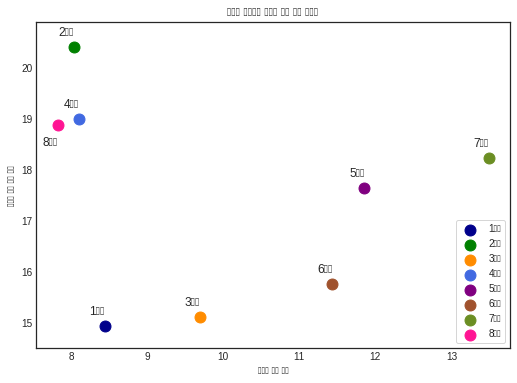

★ 점이 오른쪽 위에 있을 수록 승강기 / 화장실이 많다고 생각할 수 있습니다.★

(1-1). 역이름을 입력해주세요 (ex) 종로3가(o) , 종로3가역 (x) : 이대
(1-2). [2] 중 해당 호선을 입력해주세요 (ex) 1 : 2

(2). 누구를 위한 정보인지 선택해주세요
1 : 장애인  2 : 영유아 동반자  3: 해당 없음 2

(3). 어떤 정보를 얻고 싶은지 선택해주세요
1: 승강기 2: 화장실 3: 수유실 2


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.



## 화장실 ##

  ##  개찰구 안 화장실에 대한 정보  ##  



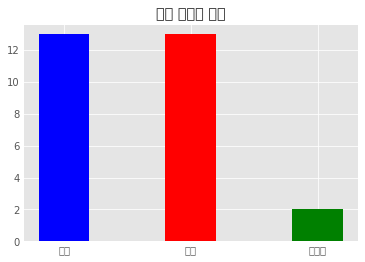

 
2 호선 이대역 및 주변 역의 어린이용변기수 정보입니다.


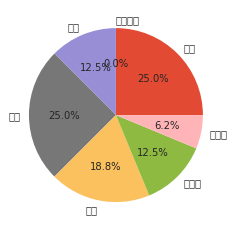


  ##  개찰구 밖 화장실에 대한 정보  ##  



,역명,호선,지상지하구분,위치
54,이대,2,지하,2층 5번출입구



(4). 해당 정보 이용이 끝났습니다. 다음 절차를 선택해주세요.
 1 : 프로그램 종료 2 : 다른 세부정보 얻고 싶음 3: 다른 역 정보 얻고 싶음 1

프로그램을 종료합니다. 감사합니다.


In [ ]:
## 전역변수 설정 ##


## 메인 프로그램 ##

# 역이름과 호선 입력받는 프로그램 
while True:
    ## 0. 처음 소개 화면
    print()
    print("지하철 정보 안내 서비스를 이용해주셔서 감사합니다.")
    print()
    show_elevator_restroom_scatter()
    print("★ 점이 오른쪽 위에 있을 수록 승강기 / 화장실이 많다고 생각할 수 있습니다.★")
    print()

    ## 1. 역이름 및 호선 입력 받기 
    while True:
        station_name=input("(1-1). 역이름을 입력해주세요 (ex) 종로3가(o) , 종로3가역 (x) : ")

        # 역이름을 잘 입력받을 때까지 입력받기 
        if station_name in total_dict.keys():
            # 호선을 잘 입력받을 때까지 무한루프 돌기
            while True:
                station_num=int(input("(1-2). %s 중 해당 호선을 입력해주세요 (ex) 1 : "%total_dict[station_name]))
                if station_num in total_dict[station_name]:
                    break
                # 해당 호선 정보가 없다고 느껴진 사람들이 나갈 수 있도록 하기
                elif station_num==-100:
                    break
                else:
                    print('- 해당 호선 정보가 없습니다. 다시 입력해주세요')
                    print("- 프로그램을 종료하고 싶으시면 호선에 '-100'을 입력해주세요")
                    print()

            # 역 이름 및 호선 잘 입력했을 경우 빠져나가는 break
            break
        
        # 원하는 역 정보가 없다고 느껴진 사람들이 나갈 수 있도록 하기
        elif station_name=='끝':
            break
        else:
            print("- 역 정보가 없습니다. 다시 입력해주세요")
            print("    (주의) 올바르게 역을 입력했으나, 해당 역 정보가 없을 수 있습니다. ")
            print("- 프로그램을 종료하고 싶으시면 역이름에 '끝'을 입력해주세요")
            print()
    
    # 사용자가 역, 호선을 입력할 때, 종료하길 원했기 때문에 프로그램을 아예 종료 시키기 
    if station_name=="끝" or station_num==-100:
        print("프로그램을 종료합니다. 감사합니다")
        break # 프로그램 자체 while 문에서 나가기 
    
    print()
    ## 2. 누구를 위한 정보인지 선택하기
    print("(2). 누구를 위한 정보인지 선택해주세요")
    while True:
        who=int(input("1 : 장애인  2 : 영유아 동반자  3: 해당 없음 "))
        # 위의 경우들이  아닌 값을 입력했을 경우 방지
        if who in [1,2,3]:
            break # 절차를 제대로 입력할 때까지 도는 while문에서 나가기
        else:
            print('잘못 입력하셨습니다. 다시 입력해주세요')

    print()
    ## 3. 세부 카테고리 정하기
    print("(3). 어떤 정보를 얻고 싶은지 선택해주세요") 
    while True:
        # 위의 경우들이  아닌 값을 입력했을 경우 방지
        while True: 
            category=int(input("1: 승강기 2: 화장실 3: 수유실 "))
            if category in [1,2,3]:
                break # 절차를 제대로 입력할 때까지 도는 while문에서 나가기
            else:
                print('잘못 입력하셨습니다. 다시 입력해주세요') 
               
        # 승강기 정보 
        print()
        if category==1:
            print('## 승강기 ##')
            show_elevator_info(station_name)

        # 화장실
        elif category==2:
            print('## 화장실 ##')
            # 개찰구 안 정보 
            print("")
            print("  ##  개찰구 안 화장실에 대한 정보  ##  ")
            print("")

            # 남녀 화장실 개수 정보 (막대 그래프)
            if who == 1:
              show_restroom_number2()
            elif who == 2:
              show_restroom_number3()
            elif who == 3:
              show_restroom_number1()

            # 역 별 변기 총 개수 비교 (파이차트)
            show_restroom_in_piechart(station_name, station_num, who)

            # 개찰구 밖 정보
            print("")
            print("  ##  개찰구 밖 화장실에 대한 정보  ##  ")
            print("")
            restroom_out_fun()
        
        # 수유실
        elif category==3:
            print('## 수유실 ##')
            show_feeding_room(station_name, station_num)
        
        print()
        ## 4. 다음 절차 정하기 (잘못 입력 했을 경우 다시 입력 받을 수 있도록 하기)
        print("(4). 해당 정보 이용이 끝났습니다. 다음 절차를 선택해주세요.")
        while True:
            next_step=input(" 1 : 프로그램 종료 2 : 다른 세부정보 얻고 싶음 3: 다른 역 정보 얻고 싶음 ")
            if next_step in ['1','2','3']:
                break # 절차를 제대로 입력할 때까지 도는 while문에서 나가기
            else:
                print("그런 절차는 없습니다.")

        # 프로그램 종료
        if next_step=='1':
            break # 세부 카테 고리 얻는 while문에서 나가기
        # 다른 세부 정보 얻기
        elif next_step=='2':
             continue
        # 다른 역 정보 얻기   
        else:
            break # 세부 카테 고리 얻는 while문에서 나가기
        
        
    # 프로그램 종료 일시, 전체
    if next_step=='1':
        print()
        print("프로그램을 종료합니다. 감사합니다.")
        break
